In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors as nn

In [2]:
def build_matrix(file_name):

    with open(file_name) as f:
        data = json.load(f)

    airports = list(data.keys())
    J = len(airports) # number of airports
    countries = []

    j = 0 # initialize aiport index

    for airport in airports:
        countries_ = list(data[airport].keys()) # list of countries for the jth airport
        for country_ in countries_:
            if len(countries) == 0:
                countries.append(country_)
                M = np.zeros((1, J)) # matrix initialization
                M[0,0] = data[airport][country_]
            else:
                if country_ in countries:
                    i = countries.index(country_)
                    M[i, j] = data[airport][country_]
                else:
                    countries.append(country_)
                    i = len(countries)-1 # last country added
                    row = np.zeros(J)
                    M = np.concatenate([M, [row]]) # add 1 row to the matrix
                    M[i, j] = data[airport][country_]
        j += 1

    return M, airports, countries

In [3]:
def plot_2_airports(airport1, airport2):
    j1 = airports.index(airport1)
    j2 = airports.index(airport2)

    non_zero_countries = []
    volumes1 = []
    volumes2 = []
    for i in range(len(countries)):
        if M[i, j1] != 0 or M[i, j2] != 0:
            non_zero_countries.append(countries[i])
            volumes1.append(M[i, j1])
            volumes2.append(M[i, j2])

    df = pd.DataFrame({airport1: volumes1, airport2: volumes2}, index=non_zero_countries)
    ax =df.plot.bar(rot=0)
    ax.set_xlabel('Country')
    ax.set_ylabel('Volume')

In [4]:
# Upload and convert data
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/My Drive/Naveler/Mabrian task/airport__origin__seats.json'

M, airports, countries = build_matrix(DATA_PATH)

Mounted at /content/drive


1st approach:
- Create vector of binary variables that indicates the countries with volume != 0 for each airport
- Calculate total volume for each airport
- Given and airport, calculate % of coincidence of country vector and total volume with other airports

In [5]:
# Inputs
airport = 'MAH'
p1 = 100 # minimum percentage of coincidence for country vector
p2 = 95 # minimum percentage of coincidence for total volume

p1 = p1/100
p2 = p2/100

# Build country vector and calculate volume for each airport
I, J = M.shape

nM = np.zeros((I, J))
volumes = {}

# M[i, j] = 1 if airport j is receiving volume from country i
# M[i, j] = 0 otherwise

for j in range(J):
    volume_ = 0 # initalize volume of jth airport
    for i in range(I):
        if M[i, j] != 0:
            volume_ += M[i, j]
            nM[i, j] = 1
    volumes[airports[j]] = volume_
    volume_ = 0

volume = volumes[airport]
j = airports.index(airport)
v = nM[:, j]

# Calculate percentages of coincidence with other airports
coincidence_dict = {}

for j_ in range(J):
    airport_ = airports[j_]
    if j_ != j:
      v_ = nM[:, j]
      dif = v - v_
      n_zeros = np.count_nonzero(dif==0) # number of equal elements
      country_vector_coincidence = n_zeros/I
      volume_coincidence = 1-abs(volumes[airport_]-volume)/volume
      coincidence_dict[airport_] = country_vector_coincidence, volume_coincidence

# Filter by percentage of coincidence
for airport in coincidence_dict:
    p1_, p2_ = coincidence_dict[airport]
    if p1_>=p1 and p2_>=p2:
        print("Airport: {}\tCountries coincidence: {}%\tVolume coincidence: {}%".format(airport, round(p1_*100, 2), round(p2_*100, 2)))

Airport: BRI	Countries coincidence: 100.0%	Volume coincidence: 98.71%
Airport: CHQ	Countries coincidence: 100.0%	Volume coincidence: 97.89%
Airport: HRG	Countries coincidence: 100.0%	Volume coincidence: 99.51%
Airport: JTR	Countries coincidence: 100.0%	Volume coincidence: 96.71%


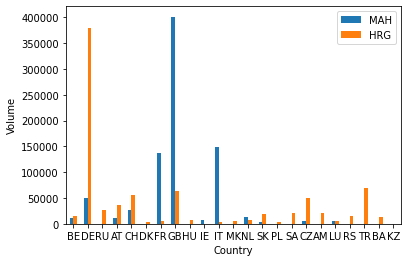

In [6]:
plot_2_airports('MAH', 'HRG')

2nd approach:
- Samples: airports (119)
- Features: countries (137)
- Representation of all samples in space with a dimensionality reduction using PCA
- Given an airport, return the k nearest airports in the reduced space using kNN

In [7]:
# Inputs
airport = 'MAH'
k = 5 # number of nearest airports

df = pd.DataFrame(M.transpose(), index=airports, columns=countries)

# Data scaling
X = df.loc[:, countries].values
scaler = MinMaxScaler()
X_rescaled = scaler.fit_transform(X)

# Dimensionality reduction
pca = PCA(n_components=0.95) # explain 95% of variance
pca.fit(X_rescaled)
#print(pca.n_components_) # 16 dimensions
principal_components = pca.transform(X_rescaled)

# kNN
model = nn()
model.fit(principal_components)

index = airports.index(airport)
point = principal_components[index, :].reshape(1, -1)

distances, indices = model.kneighbors(point, k+1)

for i in range(k+1):
    ind = indices[0, i]
    d = distances[0, i]
    airport_ = airports[ind]
    if airport_ != airport:
        print("Airport: {}\tDistance: {}".format(airports[ind], round(d, 4)))

Airport: EFL	Distance: 0.2817
Airport: OLB	Distance: 0.2958
Airport: FNC	Distance: 0.3044
Airport: PVK	Distance: 0.3056
Airport: JMK	Distance: 0.3172


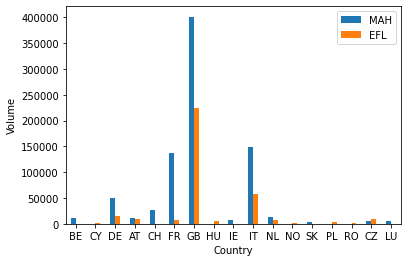

In [8]:
plot_2_airports('MAH', 'EFL')